## 1. Цели исследования.



**Целью** исследования является оценка корректность проведения A/B-теста и его результатов, который проводился с целью проверки гипотезы представителей интернет-магазина BitMotion Kit, которые предполагают, что новая версия их сайта повысит количество пользователей, совершающих покупки.

В интернет-магазине BitMotion Kit продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth. В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы. Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

В нашем распоряжении имеются данные о действиях пользователей и распределении их на группы.


## 2. Загрузка данные, оценка их целостности.


In [90]:
# Импортируем библиотеку
import pandas as pd

# Импортируем библиотеку
import matplotlib.pyplot as plt
# Импортируем библиотеку
!pip install matplotlib-venn -q
from matplotlib_venn import venn2, venn2_circles
# Импортируем библиотеки для проведения стат.тестов
import scipy
from statsmodels.stats.proportion import proportions_ztest

from math import *

In [91]:
#Загружаем данные в датасеты participants и events 

In [92]:
# Выводим информацию о датафрейме
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [93]:
# Выводим на экран первые пять строк датафрейма
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Датасет participants хранит информацию о пользователях приложения и их разделение на группы, он содержит 14525 строк и 4 колонки. Пропуски в полях отсутсвуют. Типы данных выбраны корректно.

In [94]:
# Выводим информацию о датафрейме
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [95]:
# Выводим на экран первые пять строк датафрейма
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Датасет participants хранит информацию о действиях пользователей приложения, он содержит 787286 строк и 4 колонки. Пропуски в полях присутствуют в поле details, что допустимо, так как оно содержит дополнительную информацию. Типы данных выбраны корректно, но в поле с датой стоит убрать время.

In [96]:
# В поле с датой уберем информацию о времени, оставим только дату
events['event_dt']=events['event_dt'].dt.strftime('%Y-%m-%d').astype('datetime64')

In [97]:
#Выводим уникальные значения  в поле event_name
events['event_name'].unique()

array(['End of Black Friday Ads Campaign', 'registration', 'product_page',
       'login', 'product_cart', 'purchase',
       'Start of Christmas&New Year Promo',
       'Start of CIS New Year Gift Lottery'], dtype=object)

## 3. Оценка корректности проведения теста:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [98]:
#Проверим, какие значения принимает поле ab_test в таблице ab_test_participants.
participants['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

Таблица содержит информацию об участии пользователей в нескольких тестированиях. Нас интересует тест interface_eu_test. Сохраним датафрейм с данными интересующего нас теста.

In [99]:
#Cохраняем данные с тестом interface_eu_test в новый датафрейм
participants_interface=participants[participants['ab_test']=='interface_eu_test'].reset_index(drop=True)

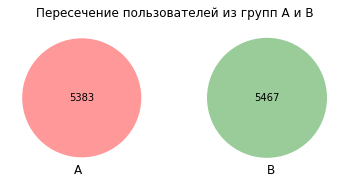

In [100]:
# Строим диаграмму Венна для проверки и визуализации пересечений пользователей групп А и В

A=set(participants_interface[participants_interface['group']=='A']['user_id'])
B=set(participants_interface[participants_interface['group']=='B']['user_id'])
venn2([A, B], set_labels=('А', 'В'))
# Отображаем график
plt.title("Пересечение пользователей из групп А и В")
plt.show()

На диаграмме видно, что перечений пользователей нет. 

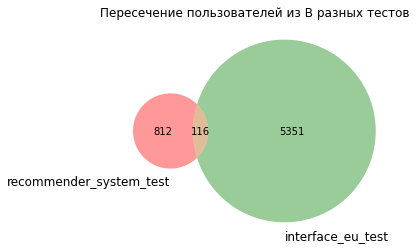

In [101]:
# Строим диаграмму Венна для проверки и визуализации пересечений пользователей групп  В 
# в разных тестах

A2=set(participants[(participants['ab_test']=='recommender_system_test')&(participants['group']=='B')]['user_id'])
B2=set(participants_interface[participants_interface['group']=='B']['user_id'])
venn2([A2, B2], set_labels=('recommender_system_test', 'interface_eu_test'))
# Отображаем график
plt.title("Пересечение пользователей из В разных тестов")
plt.show()

На диаграмме выявлено 116 пересчетений. Исключим их.

In [102]:
#Сохраним список идентификаторов пользователей из пересечения данных
users_del1=A2.intersection(B2)

In [103]:
# Пересохраним датасет без пересекающихся данных
participants_interface=participants_interface[~participants_interface['user_id'].isin(users_del1)].reset_index(drop=True)

In [104]:
# Проверим явные дубликаты
participants_interface.duplicated().sum()

0

In [105]:
# Проверим неявные дубликаты по полю с идентификатором пользователя
participants_interface.duplicated(subset=['user_id']).sum() 

0

Явные и неявные дубликаты отсутсвуют.

In [106]:
# Рассчитываем и сохраняем количество уникальных пользователей в группах
count_A=participants_interface[participants_interface['group']=='A']['user_id'].count()
count_B=participants_interface[participants_interface['group']=='B']['user_id'].count()
# Рассчитываем и сохраняем процентную разницу в 
# количестве пользователей в группах A и B
round(fabs(count_A-count_B)*100/count_A,2)

0.59

Тестовые группы по количеству пользователей практически равны. Разница незначительная, составляет лишь 0,59%.

3\.2 Проанализируем данные о пользовательской активности:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями;

In [107]:
# Сохраняем id пользователей, участвующих в эксперименте
user_ids = participants_interface['user_id'].to_list()

In [108]:
# Cохраняем данные с событиями пользователей целевого теста в новый датафрейм
events_interface=events[events['user_id'].isin(user_ids)].reset_index(drop=True)

- определим горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [109]:
# В отдельный датафрейм сохраним информацию только с регистрацией, а в другой -  без нее
events_registration=events_interface[events_interface['event_name']=='registration']
events_act=events_interface[events_interface['event_name']!='registration']

In [110]:
# Проверим явные дубликаты в датафрейме с информацией о регистрации
events_registration.duplicated().sum()

0

In [111]:
# Проверим неявные дубликаты по полю с идентификатором пользователя
events_registration.duplicated(subset=['user_id']).sum() 

0

Дубликатов в данных о регистрации нет.

In [112]:
#Объединим два новых датафрейма
events_lt=events_registration.merge(events_act, on='user_id', how='left')
events_lt

,user_id,event_dt_x,event_name_x,details_x,event_dt_y,event_name_y,details_y
0,5F506CEBEDC05D30,2020-12-06,registration,0.0,2020-12-07,login,NaN
1,5F506CEBEDC05D30,2020-12-06,registration,0.0,2020-12-07,login,NaN
2,5F506CEBEDC05D30,2020-12-06,registration,0.0,2020-12-09,login,NaN
3,5F506CEBEDC05D30,2020-12-06,registration,0.0,2020-12-09,product_page,NaN
4,5F506CEBEDC05D30,2020-12-06,registration,0.0,2020-12-10,product_page,NaN
...,...,...,...,...,...,...,...
68327,38CA3A3C4FE3FEFD,2020-12-23,registration,-1.71,2020-12-24,product_page,NaN
68328,38CA3A3C4FE3FEFD,2020-12-23,registration,-1.71,2020-12-24,product_cart,NaN
68329,16CCB1C8C4DCF1AF,2020-12-23,registration,0.0,2020-12-23,login,NaN
68330,2DDC948BD76ABC57,2020-12-24,registration,-4.29,2020-12-24,login,NaN


In [113]:
#Создаем новое поле с рассчитаным временем совершения события пользователем после регистрации
events_lt['lifetime']=events_lt['event_dt_y']-events_lt['event_dt_x']

In [114]:
#Выводим сколько уникальных значений получилось в поле lifetime
events_lt['lifetime'].nunique()

24

In [115]:
# Отфильтруем данные по полю lifetime, отберем значения меньше или равно 7 дням и 
# сохраним новый датафрейм
events_lt7=events_lt[events_lt['lifetime']<='7 days']

In [116]:
#Выводим сколько уникальных значений получилось в поле lifetime в новом датафрейме
events_lt7['lifetime'].nunique()

8

In [117]:
# В датафрейм events_lt7 добавим информацию о разделении на группы через объединение таблиц
events_lt7=participants_interface.merge(events_lt7, on='user_id')

In [118]:
# Выводим на экран первые пять строк датафрейма events_lt7
events_lt7.head()

,user_id,group,ab_test,device,event_dt_x,event_name_x,details_x,event_dt_y,event_name_y,details_y,lifetime
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07,registration,-2.38,2020-12-07,login,NaN,0 days
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07,registration,-2.38,2020-12-07,login,NaN,0 days
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07,registration,-2.38,2020-12-07,login,NaN,0 days
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07,registration,-2.38,2020-12-08,login,NaN,1 days
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07,registration,-2.38,2020-12-08,product_page,NaN,1 days


In [119]:
#Выводим уникальные значения  в поле event_name_y
events_lt7['event_name_y'].unique()

array(['login', 'product_page', 'product_cart', 'purchase'], dtype=object)

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,
- мощность теста — 80%,
- достоверность теста — 95%.

При расчёте размера выборки используем метод solve_power() из класса power.NormalIndPower модуля statsmodels.stats. Для этого установим в коде ниже параметры в соответсвии с техническим заданием.

In [120]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста
beta = 1-power
p1 = 0.3 # Базовый уровень конверсии
mde = 0.03   # Минимальный детектируемый эффект
p2=p1+mde
effect_size = (p2-p1)/np.sqrt((p1*(1-p1)+p2*(1-p2))/2)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3759


- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [121]:
# Рассчитываем общее количество посетителей в каждой группе
events_lt7_all=events_lt7.groupby('group')['user_id'].nunique().reset_index()
events_lt7_all

,group,user_id
0,A,5383
1,B,5351


In [122]:
# Рассчитываем количество посетителей, сделавших покупки, в каждой группе
events_lt7_purchase=events_lt7[events_lt7['event_name_y']=='purchase'].groupby('group')['user_id'].nunique().reset_index()
events_lt7_purchase

,group,user_id
0,A,1518
1,B,1621


- сделаем предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [123]:
# Сохраним в переменные общее число пользователей и число пользователей, 
# совершивших покупку, а также из отношение в разрезе групп
n_a=events_lt7_all.loc[0,'user_id']
n_b=events_lt7_all.loc[1,'user_id']

m_a=events_lt7_purchase.loc[0,'user_id']
m_b=events_lt7_purchase.loc[1,'user_id']

p_a=round(m_a/n_a,2)
p_b=round(m_b/n_b,2)

p_a, p_b

(0.28, 0.3)

In [124]:
# Рассчитываем разницу в доле пользователей, совершивших покупки, для выборок A и B 
round(p_b*100-p_a*100,2)

2.0

Расчеты показывают, что доля пользователей, совершивших покупки, в тестовой группе В больше на 2 процентных пункта, чем в контрольной группе А.

## 4. Оценка результатов A/B-тестирования:

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Используем Z-тест пропорций с односторонним типом альтернативной гипотезы smaller, так как мы предполагаем, что доля пользователей, совершивших покупки, в тестовой группе выше, чем в контрольной.

Формулировка гипотез выглядит следующим образом:
- Н0: Упрощение интерфейса не повлияет на конверсию зарегистрированных пользователей в покупателей.
- Н1: Упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

In [125]:
# Проверим предпосылку о достаточном количестве данных
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [126]:
# Проведем Z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

In [127]:
f'pvalue={round(p_value_ztest,2)}'

'pvalue=0.01'

In [128]:
# Интерпретируем результаты
if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение! Упрощение интерфейса не повлияет на конверсию зарегистрированных пользователей в покупателей.')
else:
    print('Нулевая гипотеза не находит подтверждения! Упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.')

Нулевая гипотеза не находит подтверждения! Упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.


- Выводы по проведённой оценке результатов A/B-тестирования.

Гипотеза заключается в следующем: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

Для проведения теста и проверки гипотезы представителей интернет-магазина BitMotion Kit, которые предполагают, что новая версия их сайта повысит количество пользователей, совершающих покупки,выбраны следующие параметры:

- Уровень значимости — 0.05.
- Минимальный детектируемый эффект, или MDE, — 3 процентных пункта.

Расчет показал, что необходимый размер выборки для каждой группы: 3759. 

Так как целевая метрика является долевой, был использован Z-тест пропорций. Тест показал значение pvalue=0.01, что меньше установленного уровня значимости.

Следовательно, альтернативная гипотеза находит подтверждение, новый интерфейс поможет увеличить долю пользователей, совершающих покупки на сайте.

Но реальный MDE оказался ниже ожидаемого - лишь 2 вместо 3 процентных пунктов.

Упрощение интерфейса сайта целесообразно.